# Power price validation and analyses

Routines for price validation and analyses of *pommesdispatch* or *pommesinvest* model runs for historical years comprising

Retrospective:
* Comparison of price statistics
* Comparison of price patterns
* Comparison of negative price and scarcity price events
* Calculation of error metrics (MAE, RSME)

Prospective:
* Plotting of prices
* Calculation of metrics

## Package imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pommesevaluation.price_validation import (
    read_and_reshape_historical_prices, read_and_reshape_smard_prices, compare_or_show_price_distribution,
    draw_price_plot, draw_weekly_plot, draw_price_duration_plot,
    calculate_error_metrics)
from pommesevaluation.pommesinvest_routines import is_leap_year

plt.rcParams.update({'font.size': 12})

## Set parameters
Most importantly, specify whether to analyze a dispatch or investment model run by choosing
`mode = "dispatch"` resp. `mode = "investment"`.

Specify path and filenames where data is stored:
* Power price results from the model.
* Historical day-ahead prices (used for validation)

In [2]:
# Choose the mode here
mode = "investment"

# Choose year to evaluate (for investment model >= 2020)
simulation_year = 2020

# Choose settings (defaults might apply!)
basic_path = "./model_results/"
path_results = {
    "dispatch": f"{basic_path}pommesdispatch/",
    "investment": f"{basic_path}pommesinvest/",
}
path_plots = "./plots/"
path_processed_data = "./data_out/"
path_historical_prices = "./data/prices/"

# Specific settings for dispatch
eeg_clusters_per_technology = 20

# Specific settings for investment
time_frame_in_years = 26
frequency = "1H"
dr_scenario = "none"
dr_scenarios = ["none", "5", "50", "95"]
sensitivities = ["pv_-50%", "pv_+50%", "prices_-50%", "prices_+50%", "consumption_-50%", "consumption_+50%"]
fuel_price_scenario = "NZE"
emissions_pathway = "long-term"
impose_investment_maxima = False

if impose_investment_maxima:
    annual_investment_limits = ""
else:
    annual_investment_limits = "_no_annual_limit"
if dr_scenario != "none":
    file_add_on = (
        f"_with_dr_{dr_scenario}_"
        f"fuel_price-{fuel_price_scenario}_"
        f"co2_price-{emissions_pathway}{annual_investment_limits}_power-prices"
    )
else:
    file_add_on = (
        f"_no_dr_50_"
        f"fuel_price-{fuel_price_scenario}_"
        f"co2_price-{emissions_pathway}{annual_investment_limits}_power-prices"
    )

# Actual model file name
model_file_name = {
    "dispatch": (
        f"dispatch_LP_start-{simulation_year}-01-01_364-days_simple_complete_"
        f"{eeg_clusters_per_technology}_res-clusters_power-prices.csv"
    ),
    "investment": (
        f"investment_LP_start-2020-01-01_{time_frame_in_years}"
        f"-years_simple_freq_{frequency}{file_add_on}.csv"
    )
}

if simulation_year < 2022:
    compare = True
    color = ["b", "r"]
    ylim = None
else:
    compare = False
    color = "b"
    ylim = [-600, 1000]

## Read in data
* Historical prices for years from 2017 to 2021 (simulate year used for validation)
* Model prices for the respective simulation year

In [3]:
historical_prices_fnames = {
    2017:
    f"{path_historical_prices}auction_spot_prices_germany_austria_2017.csv",
    2018: [
        f"{path_historical_prices}auction_spot_prices_germany_austria_2018.csv",
        f"{path_historical_prices}auction_spot_prices_germany_luxembourg_2018.csv"
    ]
}

for year in range(2019, 2021):
    historical_prices_fnames[year] = f"{path_historical_prices}auction_spot_prices_germany_luxembourg_{year}.csv"

for year in range(2021, 2024):
    historical_prices_fnames[year] = f"{path_historical_prices}smard_grosshandelspreise_stunde_2021-2023.xlsx"

historical_prices = dict()

for year, file_name in historical_prices_fnames.items():
    if year < 2021:
        historical_prices[year] = read_and_reshape_historical_prices(
            year, file_name
        )
    else:
        historical_prices[year] = read_and_reshape_smard_prices(
            year, file_name
        )

In [43]:
model_prices_full = pd.read_csv(
    path_results[mode] + model_file_name[mode],
    sep=",",
    decimal=".",
    index_col=0,
    infer_datetime_format=True
)
model_prices_full.index = pd.to_datetime(model_prices_full.index)
model_prices = model_prices_full.loc[f"{simulation_year}"]
model_prices = model_prices.rename(columns={"Power price": "model_price"})

## Visualize historical prices and calculate some statistics
* Plot power prices for years 2017 to 2021
* Calculate summary statistics for all years

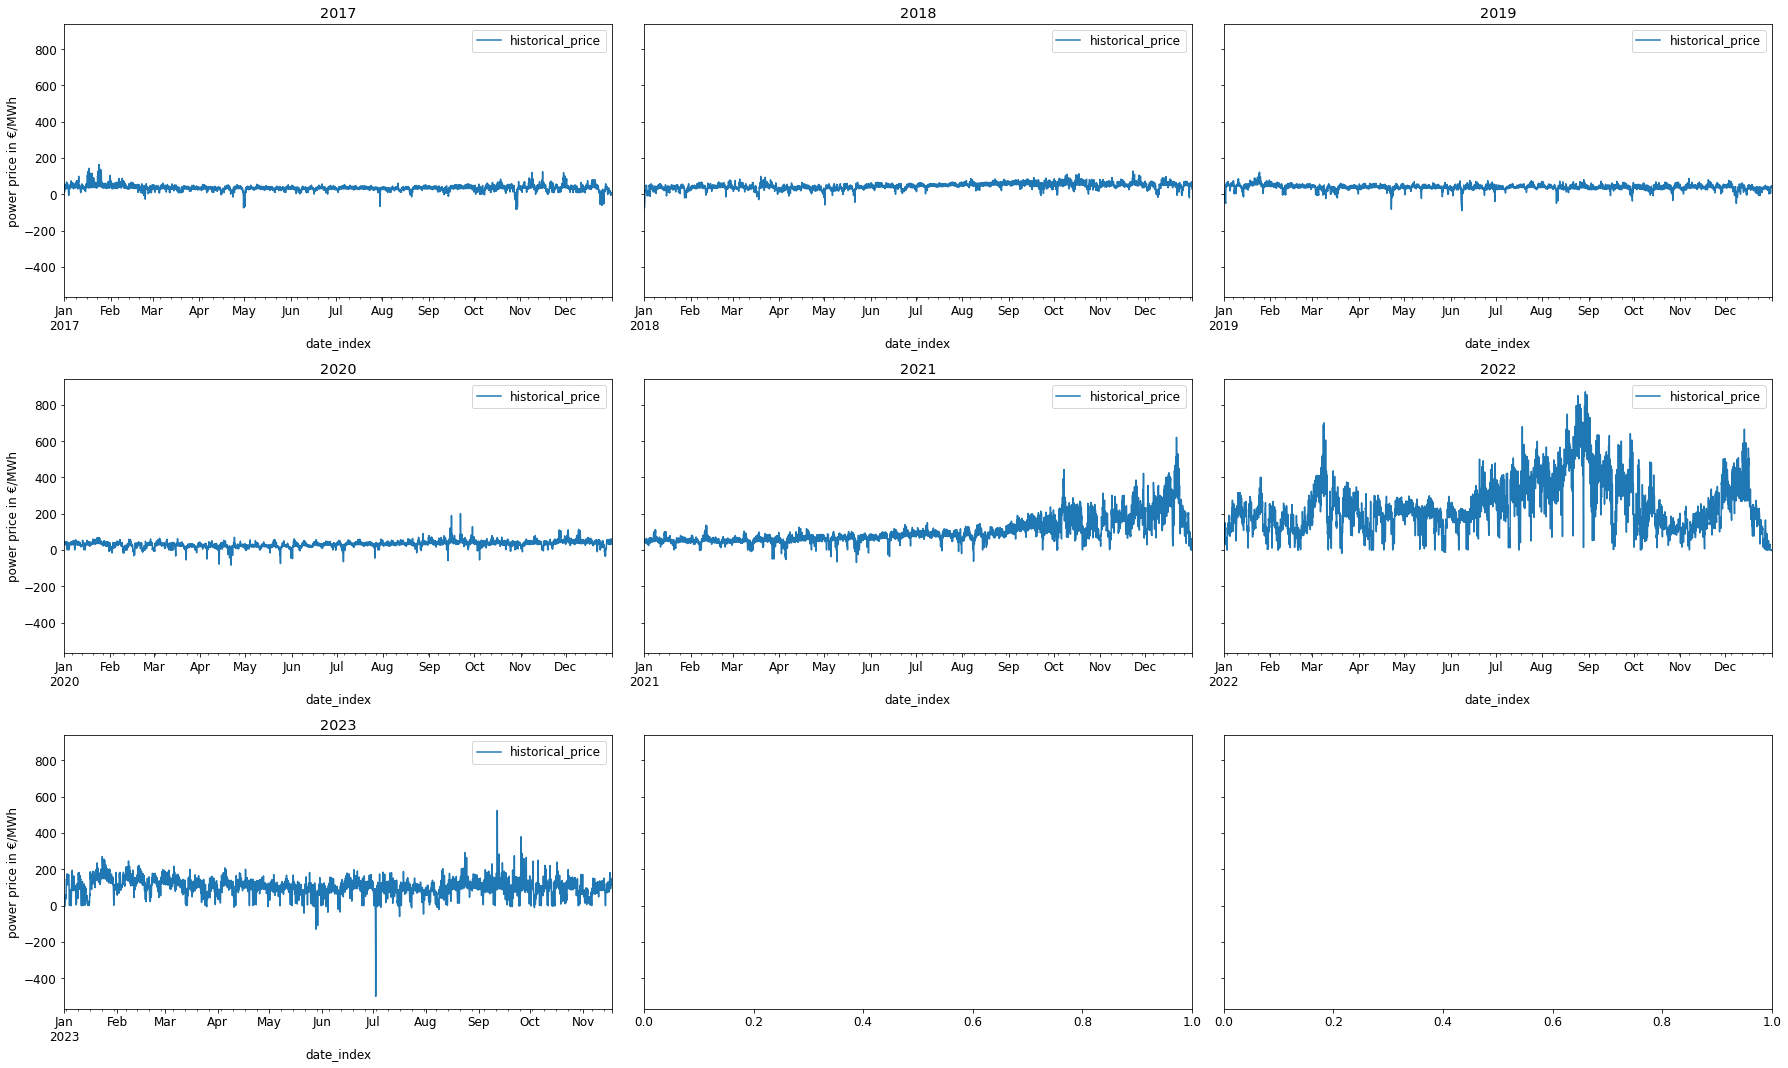

In [5]:
loc_map = {
    2017: (0, 0),
    2018: (0, 1),
    2019: (0, 2),
    2020: (1, 0),
    2021: (1, 1),
    2022: (1, 2),
    2023: (2, 0),
}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 15), sharey=True)

for key, val in historical_prices.items():
    val.plot(ax=axes[loc_map[key]])
    axes[loc_map[key]].set_title(key)

axes[0, 0].set_ylabel("power price in €/MWh")
axes[1, 0].set_ylabel("power price in €/MWh")
axes[2, 0].set_ylabel("power price in €/MWh")
plt.tight_layout()
plt.show()

In [6]:
stats_df = pd.DataFrame(index=historical_prices[2017].describe().index,
                        columns=range(2017, 2022))
stats_df.loc["negative_hours"] = 0
stats_df.loc["scarcity_hours"] = 0

for key, val in historical_prices.items():
    stats_df[key] = val.describe()
    stats_df.at["negative_hours",
                key] = val.loc[val["historical_price"] < 0].count()
    stats_df.at["scarcity_hours",
                key] = val.loc[val["historical_price"] == 3000].count()

stats_df

,2017,2018,2019,2020,2021,2022,2023
count,8760.000000,8760.000000,8760.0000,8784.000000,8760.000000,8760.000000,7704.000000
mean,34.188527,44.468920,37.6666,30.470716,96.849918,235.446143,97.397456
std,17.659501,17.771203,15.5175,17.500845,73.680947,142.809409,46.906734
min,-83.060000,-76.010000,-90.0100,-83.940000,-69.000000,-19.040000,-500.000000
25%,27.780000,34.455000,31.0600,21.750000,53.007500,134.197500,78.797500
50%,33.825000,45.090000,38.0600,30.990000,75.480000,208.340000,99.320000
75%,40.570000,54.870000,46.2700,40.250000,112.032500,310.080000,123.752500
max,163.520000,128.260000,121.4600,200.040000,620.000000,871.000000,524.270000
negative_hours,146.000000,134.000000,211.0000,298.000000,139.000000,69.000000,229.000000
scarcity_hours,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000


# Validate model results or show model results in isolation
Model results for a historical year are evaluated against historical day-ahead prices for past years.<br>
For future years, model results are displayed in isolation since there is no reference to compare against.
* Summary statistics are calculated for comparison.
* Negative price distributions are compared against each other.
* The annual price time series and duration curves are plotted against each other.
* Weekly price time series are written to disk.
* Mean average error (note: for evaluating estimates for the median) and root mean squared error (note: for evaluating estimates for the mean value) are evaluated.

## Compare summary statistics

In [7]:
if simulation_year < 2022:
    if is_leap_year(simulation_year):
        historical_prices[simulation_year] = historical_prices[simulation_year].iloc[:8760]
    
    stats_comparison_df = pd.DataFrame(index=stats_df.index,
                                       columns=["historical", "model"])

    stats_comparison_df["historical"] = historical_prices[
        simulation_year].describe()
    stats_comparison_df["model"] = model_prices.describe()
    stats_comparison_df.at["negative_hours", "historical"] = (
        historical_prices[simulation_year].loc[
            historical_prices[simulation_year].historical_price < 0].count())
    stats_comparison_df.at["negative_hours", "model"] = model_prices.loc[
        model_prices.model_price < 0].count()
    stats_comparison_df.at["scarcity_hours", "historical"] = (
        historical_prices[simulation_year].loc[
            historical_prices[simulation_year].historical_price ==
            3000].count())
    stats_comparison_df.at["scarcity_hours", "model"] = model_prices.loc[
        model_prices.model_price == 3000].count()

else:
    stats_comparison_df = pd.DataFrame(index=stats_df.index, columns=["model"])

    stats_comparison_df["model"] = model_prices.describe()
    stats_comparison_df.at["negative_hours", "model"] = model_prices.loc[
        model_prices.model_price < 0].count()
    stats_comparison_df.at["scarcity_hours", "model"] = model_prices.loc[
        model_prices.model_price == 3000].count()

stats_comparison_df

,historical,model
count,8760.000000,8760.000000
mean,30.426249,36.532340
std,17.496026,20.116489
min,-83.940000,2.280000
25%,21.697500,16.967500
50%,30.955000,40.155000
75%,40.200000,50.732500
max,200.040000,82.500000
negative_hours,298.000000,0.000000
scarcity_hours,0.000000,0.000000


## Compare resp. show negative price distribution

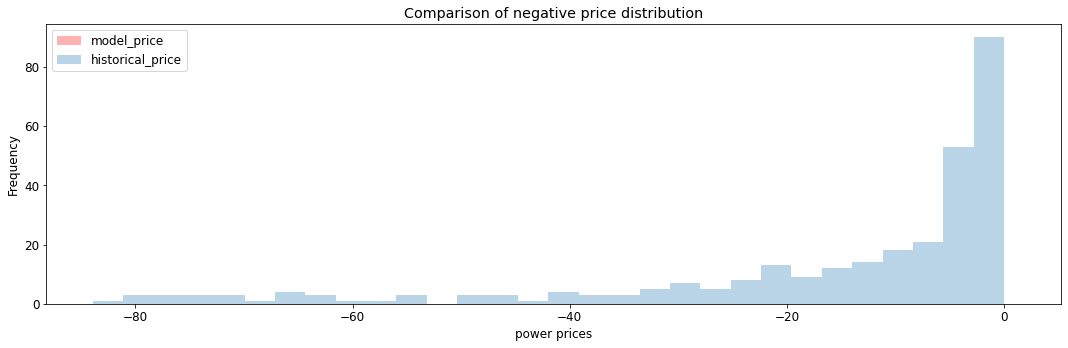

In [8]:
if simulation_year > 2022:
    historical_prices = None
    negative_historical_prices = None
else:
    negative_historical_prices = historical_prices[simulation_year].loc[
        historical_prices[simulation_year].historical_price < 0
    ].historical_price

negative_model_prices = model_prices.loc[model_prices.model_price < 0].model_price
compare_or_show_price_distribution(
    negative_model_prices, 
    negative_historical_prices,     
    save=True,
    path_plots=path_plots,
    content="negative price distribution",
    file_name=f"negative_price_distribution_{simulation_year}", 
)

## Compare annual and weekly prices against each other

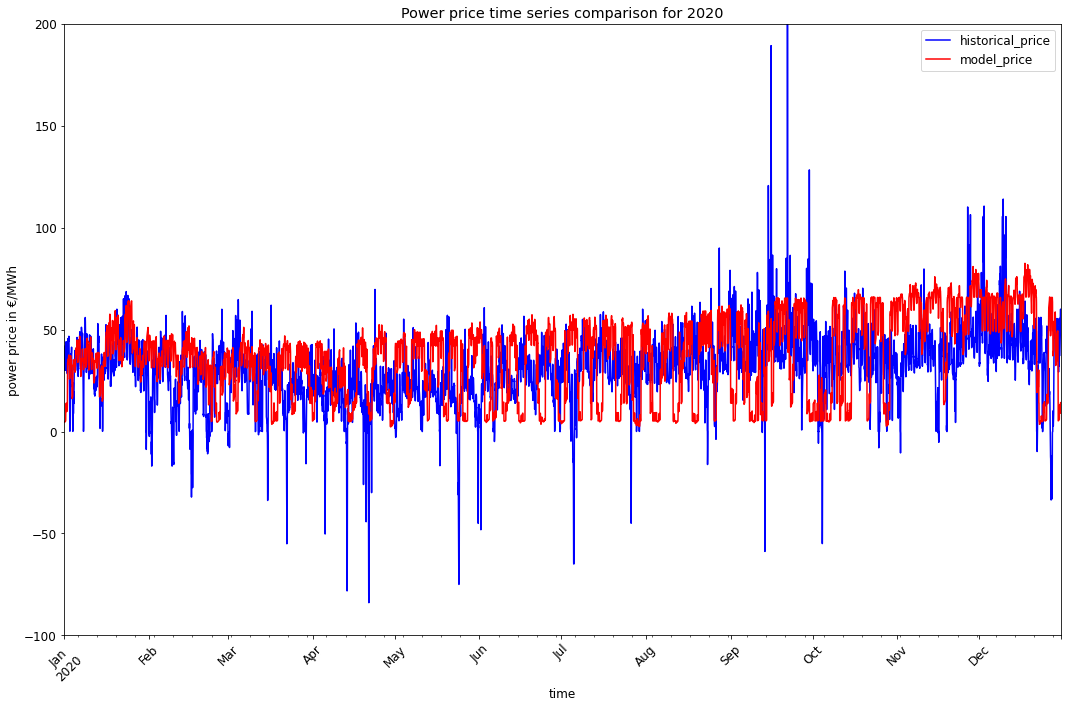

In [9]:
if simulation_year < 2022:
    # Concatenate model results and historical ones
    prices = pd.concat([historical_prices[simulation_year], model_prices], axis=1)
else:
    prices = model_prices.copy()

draw_price_plot(
    power_prices=prices,
    color=color,
    title=f"Power price time series comparison for {simulation_year}",
    y_min_max=True,
    ylim=ylim,
    show=True,
    save=True,
    file_name=f"power_price_time_series_{simulation_year}",
    figsize=(15, 10),
)

In [10]:
draw_weekly_plot(prices, simulation_year, ylim=ylim)

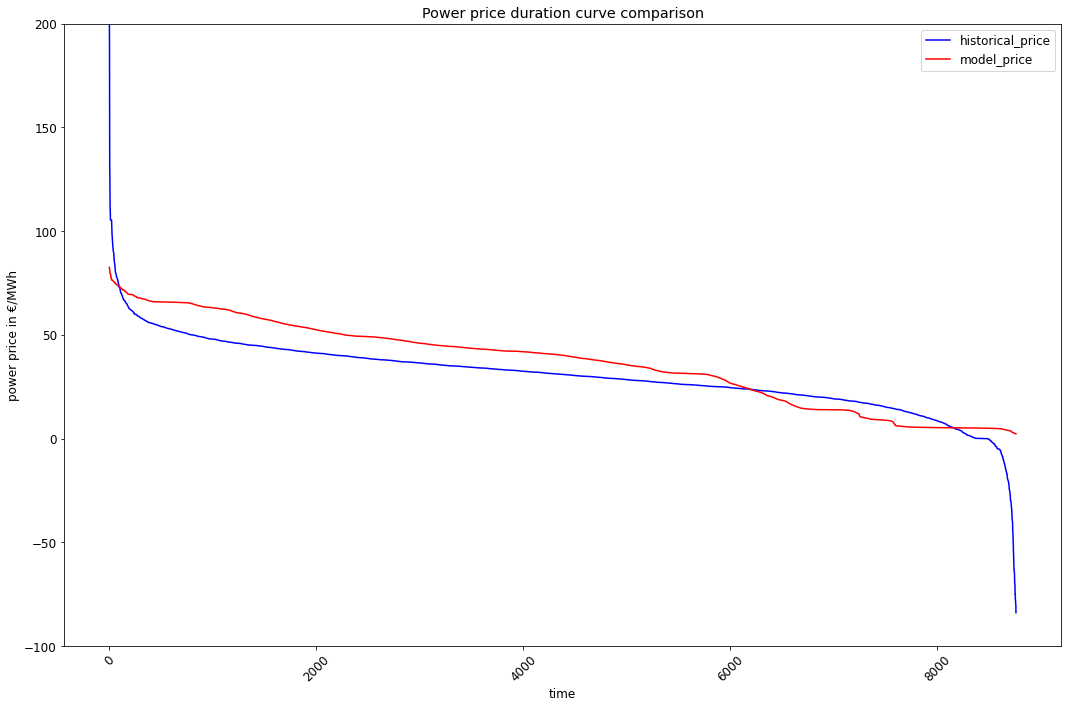

In [11]:
if simulation_year < 2022:
    draw_price_duration_plot(
        model_prices,
        historical_prices[simulation_year],
        y_min_max=True,
        ylim=[-100, 200],
        show=True,
        save=True,
        file_name=f"power_price_duration_curve_{simulation_year}",
        figsize=(15, 10),
    )
else:
    model_prices_sorted = model_prices.sort_values(
    by="model_price", ascending=False).reset_index(drop=True)

    draw_price_plot(
        model_prices_sorted,
        color="b",
        title=f"Price duration curve for {simulation_year}",
        y_min_max=False,
        show=True,
        save=True,
        file_name=f"power_price_duration_curve_{simulation_year}"
    )

## Calculate error values
Calculate mean absolute and root mean squared error for model to get an impression on model results quality

In [12]:
if simulation_year < 2022:
    error_metrics = calculate_error_metrics(historical_prices[simulation_year],
                                            model_prices)
    print(
        "Mean absolute error for model results: {:.2f} \nRoot mean squared error for model results: {:.2f}"
        .format(error_metrics["MAE"], error_metrics["RMSE"]))

Mean absolute error for model results: 19.61 
Root mean squared error for model results: 23.97


In [13]:
model_prices.min()

model_price    2.28
dtype: float64

In [14]:
model_prices.loc[f"{simulation_year}-04-30 13:00"]

model_price    3.95
Name: 2020-04-30 13:00:00, dtype: float64

In [15]:
model_prices.idxmin()

model_price   2020-04-29 12:00:00
dtype: datetime64[ns]

## Evaluate spreads
Evaluate the following kind of "spreads":
* Single hour price differentials,
* Price differentials between hours that are up to 2, 4, 8, 12 hours away from one another,
* Maximum price differentials within one day.

For each of them, draw a distribution plot as well as evaluate the maximum values.

<AxesSubplot:>

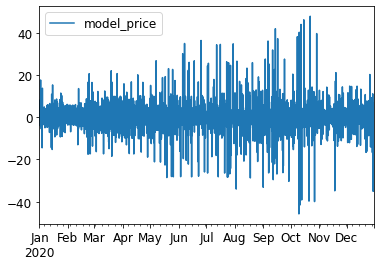

In [11]:
model_prices.diff().plot()

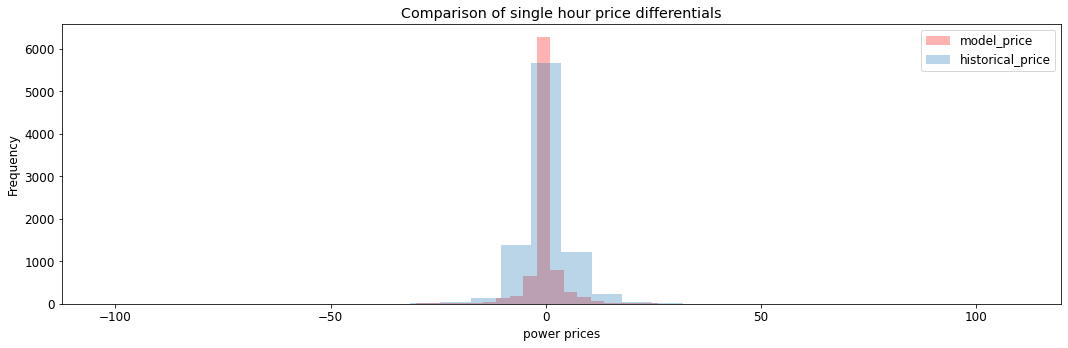

In [9]:
compare_or_show_price_distribution(
    model_prices.diff(), 
    historical_prices[simulation_year].diff(),     
    save=True,
    path_plots=path_plots,
    content="single hour price differentials",
    file_name=f"single_hour_price_differentials_{simulation_year}", 
)

In [10]:
model_prices.diff().max()

model_price    47.87
dtype: float64

In [11]:
model_prices.diff().min()

model_price   -45.79
dtype: float64

In [12]:
historical_prices[simulation_year].diff().max()

historical_price    109.23
dtype: float64

In [13]:
historical_prices[simulation_year].diff().min()

historical_price   -101.91
dtype: float64

<AxesSubplot:>

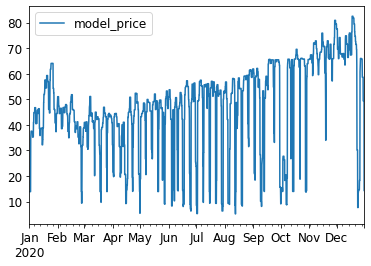

In [16]:
model_prices.rolling(24).max().plot()

<AxesSubplot:>

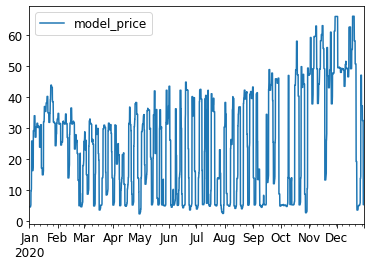

In [17]:
model_prices.rolling(24).min().plot()

In [22]:
(model_prices.rolling(24).max() - model_prices.rolling(24).min()).min()

model_price    1.12
dtype: float64

In [20]:
abs_spreads = {}
for hour_difference in [2, 4, 8, 12, 24]:
    abs_spreads[hour_difference] = model_prices.rolling(hour_difference).max() - model_prices.rolling(hour_difference).min()

<AxesSubplot:>

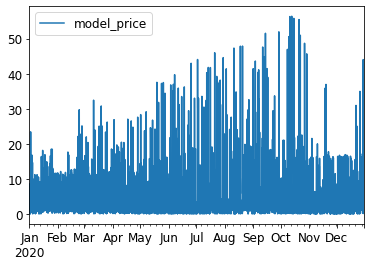

In [21]:
spreads[4].plot()

In [42]:
model_prices.loc[model_prices.model_price == model_prices.rolling(hour_difference).max().iloc[25].item()]

,model_price
2020-01-01 18:00:00,13.87
2020-01-01 19:00:00,13.87
2020-01-01 20:00:00,13.87
2020-01-01 21:00:00,13.87
2020-01-02 05:00:00,13.87
2020-02-11 23:00:00,13.87
2020-02-12 00:00:00,13.87
2020-03-19 04:00:00,13.87
2020-04-21 19:00:00,13.87


In [34]:
model_prices.head(30)

,model_price
2020-01-01 00:00:00,4.91
2020-01-01 01:00:00,4.90
2020-01-01 02:00:00,4.55
2020-01-01 03:00:00,4.52
2020-01-01 04:00:00,4.57
2020-01-01 05:00:00,4.63
2020-01-01 06:00:00,4.68
2020-01-01 07:00:00,4.74
2020-01-01 08:00:00,4.90
2020-01-01 09:00:00,4.90
